In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from econml.sklearn_extensions.model_selection import GridSearchCVList
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedGroupKFold, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pandas as pd
import math

In [45]:
from sensitivity import dml_sensitivity_bounds, dml_tvalue, dml_estimate
from sensitivity import sensitivity_bounds, tvalue, sensitivity_contours, moment_estimate
from rfriesz import RFreg, RFrr, poly_feature_fns
from sievereisz import SieveRR, SparseSieveRR, Featurizer
from debiased import DebiasedMoment
from econml.dml import LinearDML

In [4]:
# Generic machine learning regressor with cross validation
def first_stage_reg(numeric_columns=[], cv=None):
    return GridSearchCVList([
                             Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_columns)],
                                                                   remainder='passthrough')),
                                       ('lasso', Lasso())]),
                             Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), numeric_columns)],
                                                                   remainder='passthrough')),
                                       ('feat', Featurizer(degree=1, normalize=False)),
                                       ('lasso', Lasso())]),
                             RandomForestRegressor(n_estimators=100, random_state=123),
                             RFreg(reg_feature_fns=poly_feature_fns(10),
                                   min_var_leaf_on_val=True,
                                   min_impurity_decrease=1e-4, max_samples=.85, inference=False, subforest_size=1,
                                   random_state=123)
                            ],
                             param_grid_list=[
                                              {'lasso__alpha': [1e-6, 1e-5, 0.0001, .001, .01, .1, 1, 10]},
                                              {'lasso__alpha': [1e-6, 1e-5, 0.0001, .001, .01, .1, 1, 10]},
                                              {'max_depth': [3, 5],
                                               'min_samples_leaf': [10, 50]},
                                              {'reg_feature_fns': [poly_feature_fns(2)],
                                               'min_samples_leaf': [10],
                                               'min_var_fraction_leaf': [0.01, 0.1],
                                               'l2': [1e-3, 1e-2]}
                             ],
                             cv=cv,
                             scoring='neg_mean_squared_error',
                             n_jobs=-1)

In [5]:
# Returns a function that when called with data (X, y), returns a generator that when called
# returns an un-fitted regression estimator; e.g. the one with the best hyperparameters.
def reg_fn_gen(numeric_columns, cv=None, verbose=0):
    def get_reg_fn(X, y):
        est = first_stage_reg(numeric_columns, cv=cv).fit(X, y)
        if verbose > 0:
            print('Chose: ', est.best_score_, est.best_estimator_)
            print('Scores: ', [(l.best_score_, l.best_estimator_) for l in est._gcv_list])
        return lambda: clone(est.best_estimator_)
    return get_reg_fn

In [6]:
# The moment function, whose average we want to estimate: E[m(X; g)]
def moment_fn(x, test_fn):
    t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
    t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [7]:
# The negative of the reisz score: L(g) := E[2 * m(X;g) - g(X)^2]
def neg_reisz_score(model, X):
    return np.mean(2 * moment_fn(X, model.predict) - model.predict(X)**2)

In [8]:
# A generic machine learning riesz representer estimator with cross-validation
def first_stage_rr(numeric_columns, cv=None):
    return GridSearchCVList([
                            SieveRR(featurizer=Featurizer(degree=1), moment_fn=moment_fn),
                            SieveRR(featurizer=Featurizer(degree=2), moment_fn=moment_fn),
                            SieveRR(featurizer=Featurizer(degree=3), moment_fn=moment_fn),
                            SparseSieveRR(featurizer=Featurizer(degree=3), moment_fn=moment_fn, tol=1e-4),
                            SparseSieveRR(featurizer=Featurizer(degree=2), moment_fn=moment_fn, tol=1e-4),
                            SparseSieveRR(featurizer=Featurizer(degree=1), moment_fn=moment_fn, tol=1e-4),
                            RFrr(riesz_feature_fns=poly_feature_fns(10),
                                        moment_fn=moment_fn,
                                        min_var_leaf_on_val=True,
                                        min_impurity_decrease=0.001,
                                        max_samples=.65,
                                        inference=False,
                                        subforest_size=1,
                                        random_state=123)
                            ],
                            param_grid_list=[
                                   {'alpha': np.geomspace(1e-6, 1e3, 20)},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20)},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20)},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20),
                                    'l1_ratio': [.5, 1.0]},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20),
                                    'l1_ratio': [.5, 1.0]},
                                   {'alpha': np.geomspace(1e-6, 1e3, 20),
                                    'l1_ratio': [.5, 1.0]},
                                   {'riesz_feature_fns': [poly_feature_fns(2), poly_feature_fns(3)],
                                    'min_samples_leaf': [10, 50],
                                    'min_var_fraction_leaf': [0.01, 0.1],
                                    'l2': [1e-5, 1e-3],
                                    'max_depth': [5, None]}
                           ],
                           scoring=neg_reisz_score,
                           cv=cv, verbose=0, n_jobs=-1)

In [9]:
# Returns a function that when called with data X, returns a generator that when called
# returns an un-fitted riesz estimator; e.g. the one with the best hyperparameters.
def rr_fn_gen(numeric_columns, cv=None, verbose=0):
    def get_rr_fn(X):
        est = first_stage_rr(numeric_columns, cv=cv).fit(X)
        if verbose > 0:
            print('Chose: ', est.best_score_, est.best_estimator_)
            print('Scores: ', [(l.best_score_, l.best_estimator_) for l in est._gcv_list])
        return lambda: clone(est.best_estimator_)
    return get_rr_fn

In [10]:
# Data loading and manipulation

# for semi-synthetic data generation
def true_f(X):
    y = (-.7 - .4 * scipy.special.expit(3 * (1 - 2*(X[:, 1] - 10.5)))) * X[:, 0]
    y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
    return y

# def true_f(X):
#     y = -.7 * X[:, 0]
#     y += scipy.special.expit(3 * (1 - 2 * (X[:, 1] > 11.5)))
#     return y

def get_data(q=None, synthetic=False, random_seed=123):
    dfx = pd.read_csv('./401k/401k-x.csv', sep=',')
    dfy = pd.read_csv('./401k/401k-y.csv', sep=',')
    dfd = pd.read_csv('./401k/401k-d.csv', sep=',')
    X = np.hstack([dfd.values, dfx.values])
    y = dfy.values.flatten() # outcome to numpy array
    if synthetic: # impute synthetic outcome based on known relationship
        y = true_f(X) + np.random.normal(0, .2, size=X[:, 0].shape)
        print(np.mean(moment_fn(X, true_f)))
    
    # Create state-block-wise and stratified by region folds for cross validation and cross fitting
    cv = KFold(n_splits=5, shuffle=True, random_state=random_seed)
    splits = list(cv.split(X))
    return X, y, [1, 2, 3, 4], splits

In [11]:
# global result dictionaries and global parameters
ests = {}
res = {}
res_d = {}
q_grid = np.arange(1, 2)
synthetic = False # use synthetic outcome
verbose = 0

In [12]:
# General pipeline for all types of estimators to generate the estimation result we want
def generic_pipeline(estimator, q_grid, name, n_seeds=5):
    ests = {}
    res = {}
    for q in q_grid:
        print(f'q={q}')
        ests[f'q={q}'] = []
        estimate_list = []
        for random_seed in np.arange(123, 123 + n_seeds):
            X, y, num_cols, splits = get_data(q, synthetic=synthetic, random_seed=random_seed)
            estimates, model = estimator(X, y, num_cols, splits)
            print(estimates)
            estimate_list.append(estimates)
            ests[f'q={q}'].append(model)
        estimate_list = np.array(estimate_list)
        res[f'q={q}'] = {}
        res[f'q={q}'][f'{name}'] = {}
        res[f'q={q}'][f'{name}']['point'] = np.mean(estimate_list[:, 0])
        if estimate_list.shape[1] > 2:
            res[f'q={q}'][f'{name}']['stderr'] = np.sqrt(np.mean(estimate_list[:, 1]**2) 
                                                         + np.var(estimate_list[:, 0]))
        res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
    return pd.concat(res), ests

In [13]:
# Transforming results to a nicely printable dataframe where each cell
# contains point (stderr) [ci_lower, ci_upper]
def transform_res_to_df(res, q_grid, alpha=None):
    res_f = res.reset_index()
    res_d = {}
    for q in q_grid:
        key = 'all <= 11.6' if q==0 else ('all' if q==5 else f'q={q}')
        res_d[key] = {}
        for method in np.unique(res_f['level_1'].values):
            p = res.loc[(f'q={q}', method), 'point']
            if alpha is not None:
                s = res.loc[(f'q={q}', method), 'stderr']
                error = scipy.stats.norm.ppf(1 - alpha) * s
                l, u = p - error, p + error
                res_d[key][method] = f"{p:.2f} ({s:.2f}) [{l:.2f}, {u:.2f}]"
            else:
                res_d[key][method] = f"{p:.2f}"
        
    return pd.DataFrame(res_d)

In [14]:
if synthetic:
    def oracle_estimator(X, y, num_cols, splits):
        return (np.mean(moment_fn(X, true_f)),), None
    res['true'], _ = generic_pipeline(oracle_estimator, q_grid, 'true', n_seeds=1)
    res_d['true'] = transform_res_to_df(res['true'], q_grid)
    display(res_d['true'])

# Non-Linear RR Analysis

In [15]:
# fully non-parametric average derivative estimation
def nonlinrr(X, y, num_cols, splits):
    get_reisz_fn = rr_fn_gen(num_cols, cv=splits, verbose=verbose)
    get_reg_fn = reg_fn_gen(num_cols, cv=splits, verbose=verbose)
    est = DebiasedMoment(moment_fn=moment_fn,
                         get_reisz_fn=get_reisz_fn,
                         get_reg_fn=get_reg_fn,
                         n_splits=splits)
    est.fit(X, y)
    return est.avg_moment(alpha=.1), est

In [16]:
res['rr'], ests['rr'] = generic_pipeline(nonlinrr, q_grid, 'dr')

q=1
(7818.073285740907, 1142.987813520292, 5937.849942825738, 9698.296628656075)
(7747.748753805892, 1125.1960460123871, 5896.7929990350385, 9598.704508576746)
(7785.741946697645, 1158.7682108226506, 5879.559734389996, 9691.924159005293)
(7526.41841692783, 1149.4330614644334, 5635.592593835619, 9417.244240020042)
(7716.418110375388, 1143.083421302066, 5836.037491957429, 9596.798728793348)


In [17]:
res_d['rr'] = transform_res_to_df(res['rr'], q_grid, alpha=0.05)
res_d['rr']

,q=1
dr,"7718.88 (1148.50) [5829.77, 9607.99]"


# OLS analysis

In [18]:
# fully linear OLS-based average derivative estimation
def ols_estimator(X, y, num_cols, splits):
    est = OLS(y, np.hstack([np.ones((X.shape[0], 1)), X])).fit(cov_type='HC3')
    return (est.params[1], est.bse[1], *est.conf_int(alpha=.1)[1]), est

In [19]:
res['ols'], ests['ols'] = generic_pipeline(ols_estimator, q_grid, 'ols', n_seeds=1)

q=1
(5896.198421130692, 1529.7877600708202, 3379.9214755122343, 8412.47536674915)


In [20]:
res_d['ols'] = transform_res_to_df(res['ols'], q_grid, alpha=0.05)
res_d['ols']

,q=1
ols,"5896.20 (1529.79) [3379.92, 8412.48]"


# Lasso Analysis

In [21]:
# fully linear Lasso-based average derivative estimation
def lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    est = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                    ('lasso', LassoCV(cv=splits))])
    est.fit(X, y)
    p = np.mean(est.predict(np.hstack([np.ones((X.shape[0], 1)), X[:, 1:]])) 
            - est.predict(np.hstack([np.zeros((X.shape[0], 1)), X[:, 1:]])))
    return (p,), est

In [22]:
res['lasso'], ests['lasso'] = generic_pipeline(lasso_estimator, q_grid, 'lasso')

q=1
(5401.398210825367,)
(5086.581763972914,)
(5765.501892292503,)
(5765.501892292503,)
(5593.8649870789195,)


In [23]:
res_d['lasso'] = transform_res_to_df(res['lasso'], q_grid)
res_d['lasso']

,q=1
lasso,5522.57


# DML Analysis

In [24]:
# fully linear debiased Lasso-based average derivative estimation, with doubleML
def dml_lasso_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_reg = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                          ('lasso', LassoCV(cv=splits))])
    model_y = clone(model_reg).fit(X[:, 1:], y)
    model_y = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_y.named_steps['lasso'].alpha_))])
    model_t = clone(model_reg).fit(X[:, 1:], X[:, 0])
    model_t = Pipeline([('scale', ColumnTransformer([('num', StandardScaler(), num_cols)], remainder='passthrough')),
                        ('lasso', Lasso(alpha=model_t.named_steps['lasso'].alpha_))])
    est = LinearDML(model_y=model_y,
                    model_t=model_t,
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [25]:
res['dml_lasso'], ests['dml_lasso'] = generic_pipeline(dml_lasso_estimator, q_grid, 'dml_lasso')

q=1
(5933.452745624997, 1534.7898740807473, 3408.9480546348855, 8457.957436615106)
(5800.443539644564, 1530.565744680697, 3282.8869232188376, 8318.00015607029)
(5792.29439221414, 1560.4020912480687, 3225.6613529220913, 8358.927431506188)
(5924.563144268095, 1545.2652047071215, 3382.828067703676, 8466.298220832512)
(5883.496982230953, 1546.7173171028978, 3339.3733933256003, 8427.620571136305)


In [26]:
res_d['dml_lasso'] = transform_res_to_df(res['dml_lasso'], q_grid, alpha=.05)
res_d['dml_lasso']

,q=1
dml_lasso,"5866.85 (1544.75) [3325.96, 8407.74]"


# DML with Non-Linear Residualizers

In [27]:
# partially linear average derivative estimation, with doubleML
def dml_estimator(X, y, num_cols, splits):
    num_cols = [t - 1 for t in num_cols[1:]]

    model_y = reg_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], y)
    model_t = reg_fn_gen(num_cols, cv=splits, verbose=verbose)(X[:, 1:], X[:, 0])
    est = LinearDML(model_y=model_y(),
                    model_t=model_t(),
                    linear_first_stages=False,
                    cv=splits, random_state=123)
    est.fit(y, X[:, 0], W=X[:, 1:], cache_values=True)
    p = est.intercept__inference().point_estimate
    s = est.intercept__inference().stderr
    l, u = est.intercept__inference().conf_int(alpha=.1)
    return (p, s, l, u), est

In [28]:
res['dml'], ests['dml'] = generic_pipeline(dml_estimator, q_grid, 'dml')

q=1
(8576.034751972662, 1321.1316580179669, 6402.966552601396, 10749.102951343926)
(8752.786491752702, 1291.9421105419797, 6627.730825416386, 10877.842158089017)
(8545.204864064344, 1315.188199288526, 6381.912784340836, 10708.496943787852)
(8462.513994345423, 1312.7077746096368, 6303.301850151365, 10621.72613853948)
(9143.927121998038, 1305.2233632592634, 6997.025738959239, 11290.828505036836)


In [29]:
res_d['dml'] = transform_res_to_df(res['dml'], q_grid, alpha=.05)
res_d['dml']

,q=1
dml,"8696.09 (1331.66) [6505.71, 10886.47]"


# Put all results together

In [30]:
res_d_all = pd.concat(res_d)

In [31]:
heading_properties = [('font-size', '11px')]

cell_properties = [('font-size', '11px')]

dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]

res_d_all.style.set_table_styles(dfstyle)

,,q=1
rr,dr,"7718.88 (1148.50) [5829.77, 9607.99]"
ols,ols,"5896.20 (1529.79) [3379.92, 8412.48]"
lasso,lasso,5522.57
dml_lasso,dml_lasso,"5866.85 (1544.75) [3325.96, 8407.74]"
dml,dml,"8696.09 (1331.66) [6505.71, 10886.47]"


# Paper tables

In [32]:
table = {}
table['point'] = '{:.3f} ({:.3f})'.format(res['rr'].loc[(f'q={1}', 'dr'), 'point'],
                                          res['rr'].loc[(f'q={1}', 'dr'), 'stderr'])

est_list = ests['rr'][f'q={1}']
table['Bounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .04, .03, alpha=None))
table['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*sensitivity_bounds(est_list, .04, .03, alpha=.05))
table['RV(v=0)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=True, alpha=None))
table['RV(v=0,a=.05)'] = '{:.3f}'.format(tvalue(est_list, value=0, leq=True, alpha=.05))

In [35]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml_lasso'].loc[(f'q={1}', 'dml_lasso'), 'point'],
                                          res['dml_lasso'].loc[(f'q={1}', 'dml_lasso'), 'stderr'])

est_list = ests['dml_lasso'][f'q={1}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=.05))

In [36]:
table2 = {}
table2['point'] = '{:.3f} ({:.3f})'.format(res['dml'].loc[(f'q={1}', 'dml'), 'point'],
                                          res['dml'].loc[(f'q={1}', 'dml'), 'stderr'])

est_list = ests['dml'][f'q={1}']
table2['Bounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=None))
table2['CIBounds'] = '[{:.3f}, {:.3f}]'.format(*dml_sensitivity_bounds(est_list, .04, .03, alpha=.05))
table2['RV(v=0)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=None))
table2['RV(v=0,a=.05)'] = '{:.3f}'.format(dml_tvalue(est_list, value=0, leq=True, alpha=.05))

In [37]:
tabledf = pd.DataFrame({'Non-parametric': table, 'Partially linear': table2}).T[['point', 'Bounds', 'CIBounds',
                                                                                 'RV(v=0)', 'RV(v=0,a=.05)']]
tabledf

,point,Bounds,CIBounds,RV(v=0),"RV(v=0,a=.05)"
Non-parametric,7718.880 (1148.500),"[2925.944, 12511.817]","[938.947, 14488.127]",0.056,0.041
Partially linear,8696.093 (1331.656),"[4402.203, 12989.984]","[2153.443, 15241.546]",0.069,0.051


In [38]:
print(tabledf.to_latex())

\begin{tabular}{llllll}
\toprule
{} &                point &                 Bounds &               CIBounds & RV(v=0) & RV(v=0,a=.05) \\
\midrule
Non-parametric   &  7718.880 (1148.500) &  [2925.944, 12511.817] &   [938.947, 14488.127] &   0.056 &         0.041 \\
Partially linear &  8696.093 (1331.656) &  [4402.203, 12989.984] &  [2153.443, 15241.546] &   0.069 &         0.051 \\
\bottomrule
\end{tabular}



# Analysis by income

In [50]:
def plot_by_income(nq, method, dml):
    if dml:
        sens_fn, est_fn = dml_sensitivity_bounds, dml_estimate
    else:
        sens_fn, est_fn = sensitivity_bounds, moment_estimate
    X, _, _, _ = get_data(1, synthetic=synthetic, random_seed=123)
    inds = np.argsort(X[:, 2])
    splits = np.array_split(inds, nq)
    point = np.zeros(nq)
    stderr = np.zeros(nq)
    bounds = np.zeros((nq, 2))
    cibounds = np.zeros((nq, 2))
    qgr = np.arange(nq)
    for q in qgr:
        points, stderrs = zip(*[est_fn(est, inds=splits[q]) for est in ests[method]['q=1']])
        points, stderrs = np.array(points), np.array(stderrs)
        point[q] = np.mean(points)
        stderr[q] = np.sqrt(np.mean(stderrs**2) + np.var(points))
        bounds[q, :] = sens_fn(ests[method]['q=1'], .04, .03, inds=splits[q])
        cibounds[q, :] = sens_fn(ests[method]['q=1'], .04, .03, alpha=0.05, inds=splits[q])
        
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.fill_between(qgr, point - 1.645*stderr, point + 1.645*stderr, alpha=.4)
    plt.plot(qgr, point)
    plt.xlabel("Income groups by quartiles")
    plt.ylabel("ATE")

    plt.subplot(1, 2, 2)
    plt.fill_between(qgr, cibounds[:, 0], cibounds[:, 1], alpha=.4)
    plt.fill_between(qgr, bounds[:, 0], bounds[:, 1], alpha=.4)
    plt.plot(qgr, point)
    plt.xlabel("Income groups by quartiles")
    plt.ylabel("ATE")
    plt.tight_layout()
    plt.show()

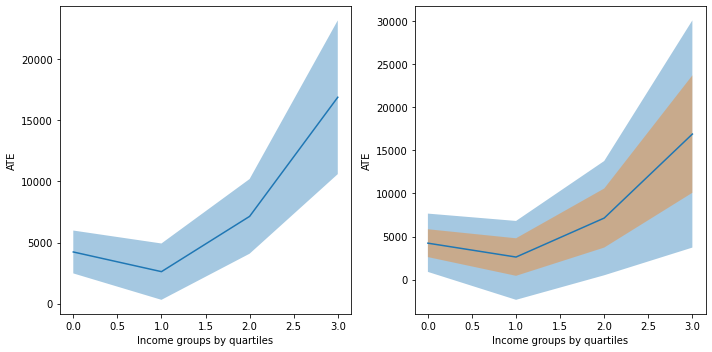

In [54]:
plot_by_income(4, 'rr', False)

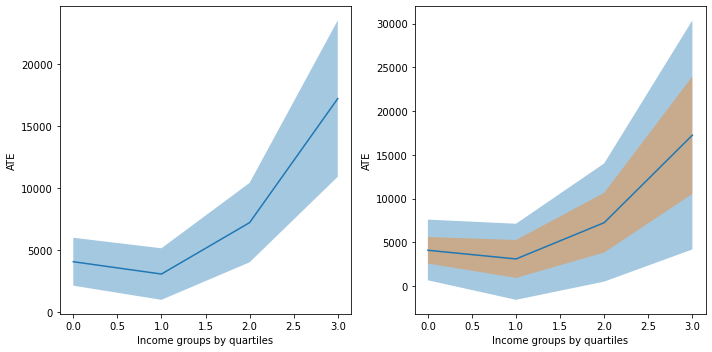

In [55]:
plot_by_income(4, 'dml', True)

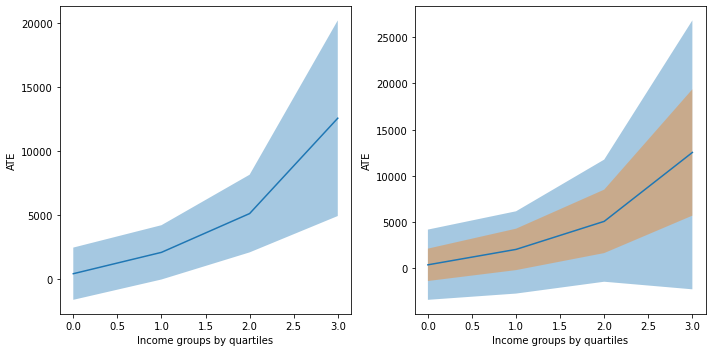

In [56]:
plot_by_income(4, 'dml_lasso', True)